In [6]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

from point_configuration import PointConfiguration

In [81]:
from algorithms import reconstruct_mds
from algorithms import reconstruct_srls
from algorithms import reconstruct_acd
from algorithms import reconstruct_sdp
from algorithms import reconstruct_dwmds
import sys

def localization_error(point_estimate):
    err = np.linalg.norm(p.points[:n] - point_estimate[:n])**2/n
    return err

def first_point_error(point_estimate):
    err = np.linalg.norm(p.points[:1] - point_estimate[:1])**2
    return err

def try_method(errs_dict, failed, method, error_type, **kwargs):
    try: 
        xhat = execute_method(method, kwargs)
        err = error_type(xhat)
        errs_dict[method][i].append(err)
        return xhat, err
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise
        failed.append(method)
        
def execute_method(method, kwargs):
    if method == 'MDS':
        xhat = reconstruct_mds(noisy_edm, real_points=p.points, method='geometric')
    
    if method == 'MDSoptspace':
        xhat = reconstruct_mds(noisy_edm, real_points=p.points, 
                                   method='geometric', mask=weights, 
                                   completion='optspace', print_out=True)
    if method == 'MDSalternate':
        xhat = reconstruct_mds(noisy_edm, real_points=p.points, 
                                   method='geometric', mask=weights, 
                                   completion='alternate', print_out=True)
    if method == 'SDR':
        x_SDRold, EDMbest = reconstruct_sdp(noisy_edm, weights, lamda, p.points)
        ### Added to avoid strange "too large to be a matrix" error
        xhat = np.zeros((N, d))
        xhat[:,:] = x_SDRold
    if method == 'ACD':
        xhat, fs, err_edms, err_points = reconstruct_acd(noisy_edm, weights, X_0=x0.copy(), 
                                                          real_points=p.points)
    if method == 'dwMDS':
        X_bar = kwargs.get('X_bar', None)
        r = kwargs.get('r', None)
        xhat, costs = reconstruct_dwmds(noisy_edm, X0=x0.copy(), W=weights, n=n, 
                                       X_bar=X_bar, r=r)
    if method == 'SRLS':
        xhat = reconstruct_srls(noisy_edm, p.points, indices=range(n))
    return xhat
    
def create_weights(N, proportion=0.5, method='all'):
    weights = np.ones((N,N))
    weights[range(N), range(N)] = 0
    
    if method == 'none':
        return weights
    
    # create indices object to choose from
    elif method == 'all':
        all_indices = np.triu_indices(N,1)
    elif method == 'first':
        all_indices = [np.zeros(N-1).astype(np.int), np.arange(1,N).astype(np.int)]
    ntotal = len(all_indices[0])
    nchosen = int(ntotal * proportion)
    
    # randomly choose from indices and set to 0
    choice = np.random.choice(ntotal, nchosen, replace=False)
    chosen = [all_indices[0][choice], all_indices[1][choice]]
    weights[chosen] = 0
    weights[chosen[1],chosen[0]] = 0
    return weights
    
print(create_weights(9, method='first'))
print(create_weights(9, method='all'))

[[ 0.  0.  1.  0.  0.  1.  0.  1.  1.]
 [ 0.  0.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  0.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  0.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  0.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  0.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  0.]]
[[ 0.  0.  0.  0.  1.  1.  1.  0.  1.]
 [ 0.  0.  1.  1.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.  0.  0.  1.  1.]
 [ 0.  1.  1.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  1.  1.  1.]
 [ 1.  0.  0.  1.  0.  1.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  1.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  1.  1.  1.  0.]]


In [8]:
import copy
from basics import create_noisy_edm, get_edm
#from plots_cti import plot_point_sets_3d, plot_matrix

# Global settings
N = 10
d = 3
lamda = 1000
square_size = 5
max_it = 10

## Simulation A

In [ ]:
num_it = 10
name = 'A_complete'
ms = 9
noises = np.logspace(-2,0.5,10) 
p = np.arange
x0 = np.zeros((N, d)) # set by method_x0
method_x0 = 'SDR'
method_weights = 'none'

errs = [[] for noise in noises]
errs_dict = {
    'noise':copy.deepcopy(errs),
    'MDS':copy.deepcopy(errs),
    #'MDSalternate':copy.deepcopy(errs),
    #'MDSoptspace':copy.deepcopy(errs),
    'SDR':copy.deepcopy(errs),
    'ACD':copy.deepcopy(errs),
    'dwMDS':copy.deepcopy(errs),
    'SRLS':copy.deepcopy(errs)}

In [21]:
num_it = 30
name = 'A_missing'
m = 9
noises = np.logspace(-2,0.5,10) 
x0 = np.zeros((N, d)) # set by method_x0 
method_x0 = 'SDR'
method_weights = 'first'

errs = [[] for noise in noises]
errs_dict = {
    'noise':copy.deepcopy(errs),
    'MDS':copy.deepcopy(errs),
    'MDSalternate':copy.deepcopy(errs),
    'MDSoptspace':copy.deepcopy(errs),
    'SDR':copy.deepcopy(errs),
    'ACD':copy.deepcopy(errs),
    'dwMDS':copy.deepcopy(errs),
    'SRLS':copy.deepcopy(errs)}

In [22]:
n = N - m
n_edges = N*(N-1)
p = PointConfiguration(N, d)

for it in range(num_it):
    print(it)
    p.set_points('random',size=square_size)
    
    for i, noise in enumerate(noises):
        # missing distances
        weights = create_weights(N, method=method_weights)
        
        failed = []
        noisy_edm = create_noisy_edm(p.edm, noise, n)
        err_noise = np.linalg.norm(np.sqrt(p.edm) - np.sqrt(noisy_edm))/n_edges**0.5
        errs_dict['noise'][i].append(err_noise)
        
        for method in errs_dict.keys():
            if method != 'noise':
                if method == method_x0:
                    x0 = try_method(errs_dict, failed, method, localization_error)
                else:
                    try_method(errs_dict, failed, method, localization_error)
        
        if len(failed)>0:
            print('exception occured in',failed)
        else:
            for method in errs_dict.keys():
                print('error {}: {:2.2e}'.format(method, errs_dict[method][i][-1]))
np.save('results/{}_errs_dict.npy'.format(name),errs_dict)

0
0.01
alternate: relative error:0.0017095538646835075
optspace: relative error:0.0002661306853134966
smallest eigenvalue is zero
error noise: 5.68e-03
error MDS: 1.83e-04
error MDSalternate: 4.46e-02
error MDSoptspace: 2.98e-03
error SDR: 3.20e-04
error ACD: 3.36e-04
error dwMDS: 3.41e-04
error SRLS: 3.94e-04
0.0189573565241
alternate: relative error:0.00018452858213984763
optspace: relative error:0.04145499391858079
smallest eigenvalue is zero
error noise: 7.12e-03
error MDS: 1.08e-04
error MDSalternate: 1.30e-02
error MDSoptspace: 2.58e+00
error SDR: 1.80e-03
error ACD: 1.76e-03
error dwMDS: 1.92e-03
error SRLS: 2.39e-04
0.035938136638
alternate: relative error:0.005262358137624393
optspace: relative error:0.0028836380955403296
smallest eigenvalue is zero
error noise: 1.67e-02
error MDS: 3.06e-03
error MDSalternate: 2.20e-01
error MDSoptspace: 4.51e-02
error SDR: 1.19e-02
error ACD: 1.08e-02
error dwMDS: 4.92e-03
error SRLS: 5.92e-03
0.0681292069058
alternate: relative error:0.01341

## Simulation B

In [84]:
num_it = 1
name = 'B_complete'
m = 5
#noises = np.logspace(-2,0.5,10) 
noises = np.logspace(-2,-1,1) 
x0 = np.zeros((N, d)) # set by method_x0 
method_x0 = 'SDR'
method_weights = 'none'
edm_noise = 1.0

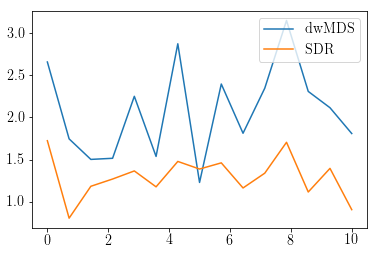

In [122]:
rs = np.linspace(0,10,15)

p = PointConfiguration(N, d)
weights = create_weights(N, method=method_weights)

errs = [[] for r in rs]
errs_dict = {'dwMDS':copy.deepcopy(errs),
             'SDR':copy.deepcopy(errs)}

for i, r_factor in enumerate(rs):
    for trials in range(20):
        p.set_points('random',size=square_size)
        noisy_edm = create_noisy_edm(p.edm, edm_noise, n)
        p.points[:n, :] += np.random.normal(0, noise, (n, p.d))
        X_bar = p.points[:n] 

        r = r_factor * np.ones((n,))
        r[0] = 0.0
        x0, err = try_method(errs_dict, failed, 'SDR', first_point_error)
        try_method(errs_dict, failed, 'dwMDS', first_point_error, X_bar=X_bar, r=r)

plt.figure()
for key, val in errs_dict.items():
    val_arr = np.array(val)
    val_arr = np.mean(val_arr, axis=1)
    plt.plot(rs, val_arr, label=key)
plt.legend(loc='best')
plt.show()

In [120]:
r_factor=3. #value of all elements of r for dwMDS

errs = [[] for noise in noises]
errs_dict = {
    'noise':copy.deepcopy(errs),
    'MDS':copy.deepcopy(errs),
    'MDSalternate':copy.deepcopy(errs),
    'MDSoptspace':copy.deepcopy(errs),
    'SDR':copy.deepcopy(errs),
    'ACD':copy.deepcopy(errs),
    'dwMDS':copy.deepcopy(errs),
    'SRLS':copy.deepcopy(errs)}

n = N - m
n_edges = N*(N-1)
p = PointConfiguration(N, d)

for it in range(num_it):
    print(it)
    p.set_points('random',size=square_size)

    for i, noise in enumerate(noises):
        weights = create_weights(N, method=method_weights)

        # add noise to points.
        p.points[:n, :] += np.random.normal(0, noise, (n, p.d))

        # arguments for dwMDS: 
        X_bar = p.points[:n] 
        r = r_factor * np.ones((n,))
        r[0] = 0.0

        failed = []
        noisy_edm = create_noisy_edm(p.edm, edm_noise, n)
        err_noise = np.linalg.norm(np.sqrt(p.edm) - np.sqrt(noisy_edm))/n_edges**0.5
        errs_dict['noise'][i].append(err_noise)

        for method in errs_dict.keys():
            if method != 'noise':
                if method == method_x0:
                    x0, err = try_method(errs_dict, failed, method, first_point_error)
                else:
                    __, err = try_method(errs_dict, failed, method, first_point_error,
                                        X_bar=X_bar, r=r)

        if len(failed)>0:
            print('exception occured in',failed)
        else:
            for method in errs_dict.keys():
                print('error {}: {:2.2e}'.format(method, errs_dict[method][i][-1]))
np.save('results/{}_errs_dict.npy'.format(name),errs_dict)

0
alternate: relative error:0.0
optspace: relative error:0.002413750321466636
error noise: 9.79e-01
error MDS: 9.17e-01
error MDSalternate: 9.17e-01
error MDSoptspace: 8.97e-01
error SDR: 1.56e+00
error ACD: 1.26e+00
error dwMDS: 1.15e+00
error SRLS: 5.57e+00
